# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [74]:
from thick_ptycho.sample_space.sample_space import SampleSpace
from thick_ptycho.forward_model.solver import ForwardModel
from thick_ptycho.utils.visualisations import Visualisation

import numpy as np

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

In [75]:
bc_type = "impedance"     # Boundary condition type 
probe_type = "airy_disk"                 # Airy disk probe

# Constants
wavelength = 0.635  # μm
k0 = 2 * np.pi / wavelength

# background refractive index
nb = 1.0  # background refractive index
# Define refractive index perturbation
# delta: real part, beta: imaginary part (absorption)
delta = 0.01
beta = 0.01
refractive_index_perturbation = - delta - beta*1j 

# Spatial dimensions
xlims = [0, 40]  # μm
zlims = [0, 80]  # μm
continuous_dimensions = [xlims, zlims]


# Choose nz to satisfy paraxial resolution:
# Use approx. λ/4 axial resolution → ∆z ≈ λ / 4 ≈ 0.125 μm → nz = (z_range / ∆z)
z_range = zlims[1] - zlims[0]
dz = wavelength / 2
nz = int(z_range / dz)  
print(f"{nz=}")

# Discrete space parameters
probe_dimensions = [64]             # Discrete Probe dimensions
probe_diameter = int(0.4 * min(probe_dimensions))  # Diameter if using initial condition "disk"
scan_points = 3                     # Single probe
step_size = 30                     # Step size in pixels


# Discrete space limits (pixels)
min_nx = int(scan_points * step_size + probe_dimensions[0])
print(f"{min_nx=}")
# Number of pixels in x directions
#nx = 92

discrete_dimensions = [
    min_nx,
    nz
    ]   # Discrete dimensions

nz=251
min_nx=154


### 3. Create Sample Space

Initialize the sample space. The sample space dimensions are defined here as well
as it's discritization in pixels.

In [76]:

sample_space = SampleSpace(
    continuous_dimensions, # sample space dimensions in nanometers (x, z) or (x, y, z)
    discrete_dimensions,   # sample space dimensions in pixels (nx, nz) or (nx, ny, nz)
    probe_dimensions,        # shape of the detector in pixels - subset of (nx) or (nx, ny)
    scan_points,           # number of ptychography scan points or sqrt(scan_points) for square scan
    step_size,
    bc_type,               # boundary condition type (impedance, dirichlet, neumann)
    probe_type,
    k0,            # wavenumber in 1/nm
    n_medium=nb,
    probe_diameter=probe_diameter,
)
sample_space.summarize_sample_space()

Summary of the scan (continuous):
    Sample space x: 40 um
    Sample space z: 80 um
    Probe Diameter: 6.54 um
    Number of scan points: 3
    Max Overlap: -1.26 um 



### 4. Add Objects

Add rectangles with specified refractive indices to the sample space.

In [77]:
# gaussian_blur = 3

# # Add 6 spheres of varying diameters and positions
# common_side_length = 1  # μm diameter
# common_depth = 1  # μm depth

# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,  # μm diameter
#                         centre=(100/300*xlims[1], 50/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(150/300*xlims[1], 80/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(200/300*xlims[1], 110/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(220/300*xlims[1], 80/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(125/300*xlims[1], 70/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(175/300*xlims[1], 50/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(100/300*xlims[1], 110/125*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)

sample_space.generate_sample_space()

### 5. Solve the Forward Model

Solve the forward problem both iteratively and as a full system for sub-samples
and the full sample.

In [78]:
# # Solve Thin Sample, Iterative
# forward_model_iterative_thin = ForwardModel(sample_space,
#                              full_system_solver=False,
#                              thin_sample=True)

# # Iterative solution
# print("Solving iteratively for thin sample...")
# solution_iterative_thin = forward_model_iterative_thin.solve(verbose=True)

In [79]:
# Solve Full Space Space, Iterative
forward_model_iterative_full = ForwardModel(sample_space,
                             full_system_solver=False,
                             thin_sample=False)

# Iterative solution
print("Solving iteratively for full sample...")
solution_iterative_full = forward_model_iterative_full.solve(verbose=True)


Solving iteratively for full sample...
[BC debug] Impedance beta_x=(-0.6119999999999999+0j)
Time to solve scan 1/3: 0.003996610641479492 seconds
Time to solve scan 2/3: 0.0036237239837646484 seconds
Time to solve scan 3/3: 0.003914833068847656 seconds


In [80]:
# # Solve Full System, All-At-Once
# forward_model_fullsystem_thin = ForwardModel(sample_space,
#                              full_system_solver=True,
#                              thin_sample=True)

# # Full system solution
# print("Solving full system for thin sample...")
# solution_fullsystem_thin = forward_model_fullsystem_thin.solve(verbose=True)

### 6. Solve in Reverse
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

In [81]:
# # Set Exit wave to initial condition for reverse
# print("Solving iteratively for thin sample in reverse...")
# initial_condition = solution_iterative_thin[..., -1].copy()  # Copy the last frame of the solution
# solution_iterative_thin_reverse = forward_model_iterative_thin.solve(reverse=True,
#                                                       initial_condition=initial_condition)

# import numpy as np
# # Compute RMSE between solution_iterative_solve_thin_reverse and itself
# rmse = np.sqrt(np.mean(np.abs(solution_iterative_thin[..., 0] - solution_iterative_thin_reverse[..., -1]) ** 2))
# print(f"RMSE between forward and backward solutions: {rmse}")

In [82]:
# # Set Exit wave to initial condition for reverse
# print("Solving iteratively for full sample in reverse...")
# initial_condition = solution_iterative_full[..., -1].copy()  # Copy the last frame of the solution
# solution_iterative_full_reverse = forward_model_iterative_full.solve(reverse=True,
#                                                       initial_condition=initial_condition)

# import numpy as np
# # Compute RMSE between solution_iterative_solve_full_reverse and itself
# rmse = np.sqrt(np.mean(np.abs(solution_iterative_full[..., 0] - solution_iterative_full_reverse[..., -1]) ** 2))
# print(f"RMSE between forward and backward solutions: {rmse}")

### 7. Visualisations

Module to help view sample space and solutions.

In [83]:
# Import Visualisation module
from thick_ptycho.utils.visualisations import Visualisation

visualisation = Visualisation(sample_space=sample_space)

In [84]:
# # Visualise the Sample Space
# visualisation.plot(solution=sample_space.n_true,title="Sample Space")

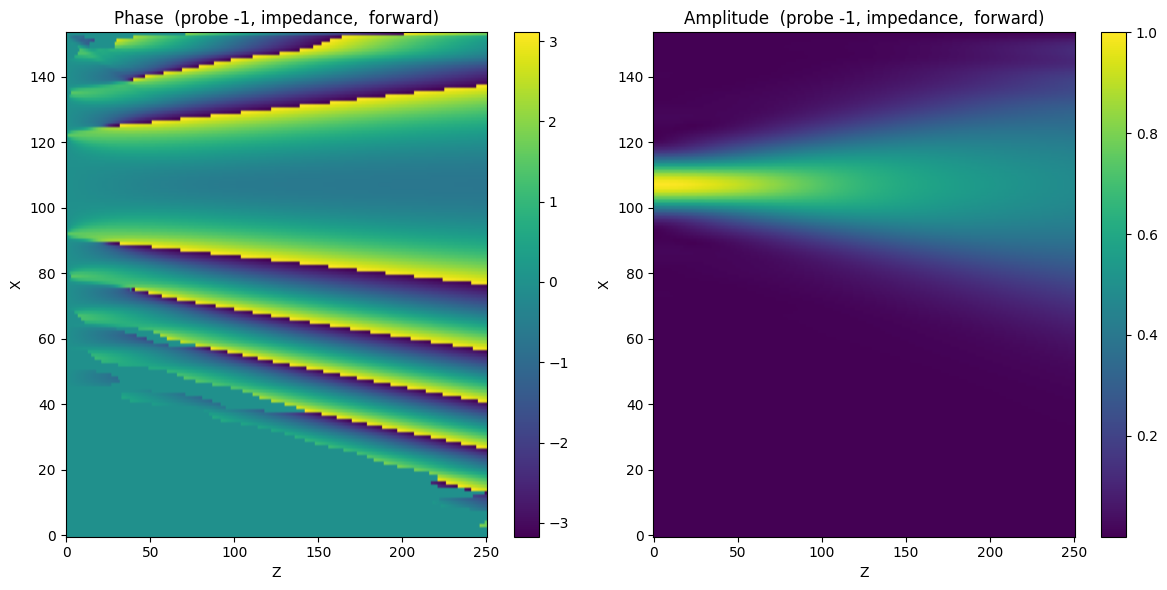

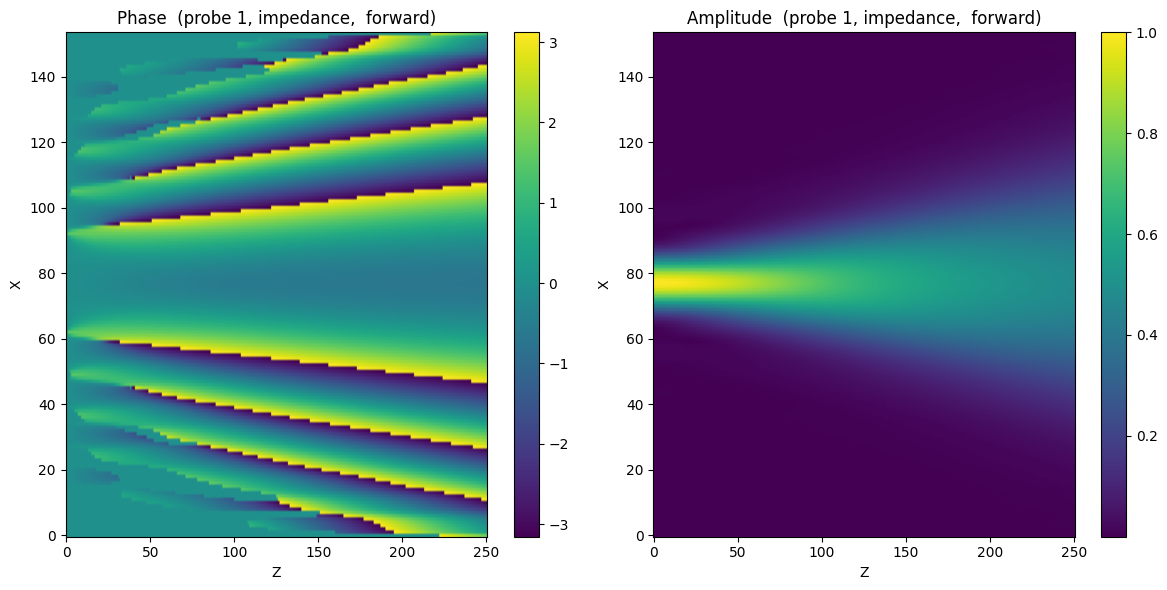

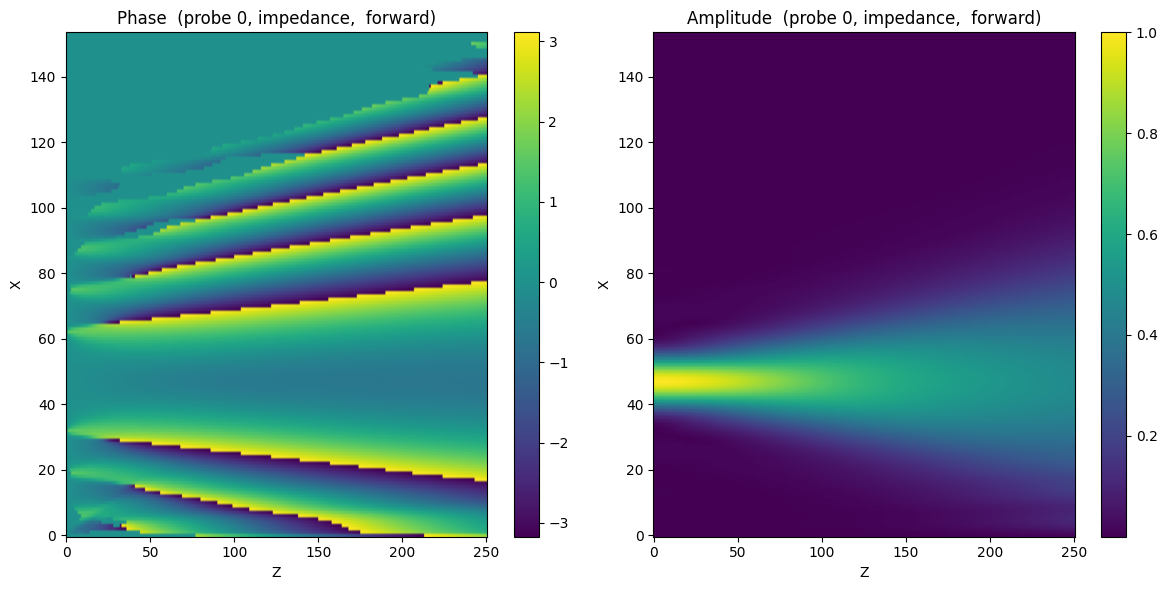

In [85]:
# Plot Solution for Full Sample Solves
visualisation.plot(solution=solution_iterative_full,probe_index=-1)
visualisation.plot(solution=solution_iterative_full)
visualisation.plot(solution=solution_iterative_full,probe_index=0)

### Compare with Homogeneous Sample

In [86]:
sample_space = SampleSpace(
    continuous_dimensions, # sample space dimensions in nanometers (x, z) or (x, y, z)
    discrete_dimensions,   # sample space dimensions in pixels (nx, nz) or (nx, ny, nz)
    probe_dimensions,        # shape of the detector in pixels - subset of (nx) or (nx, ny)
    scan_points,           # number of ptychography scan points or sqrt(scan_points) for square scan
    step_size,
    bc_type,               # boundary condition type (impedance, dirichlet, neumann)
    probe_type,
    k0,            # wavenumber in 1/nm
    n_medium=nb,
)
sample_space.generate_sample_space()

# Solve Full Space Space, Iterative
forward_model_iterative_full = ForwardModel(sample_space,
                             full_system_solver=False,
                             thin_sample=False)

# Iterative solution
print("Solving iteratively for full sample...")
solution_iterative_full_homogeneous = forward_model_iterative_full.solve(verbose=True)

Solving iteratively for full sample...
[BC debug] Impedance beta_x=(-0.6119999999999999+0j)
Time to solve scan 1/3: 0.004184722900390625 seconds
Time to solve scan 2/3: 0.003392457962036133 seconds
Time to solve scan 3/3: 0.0030481815338134766 seconds


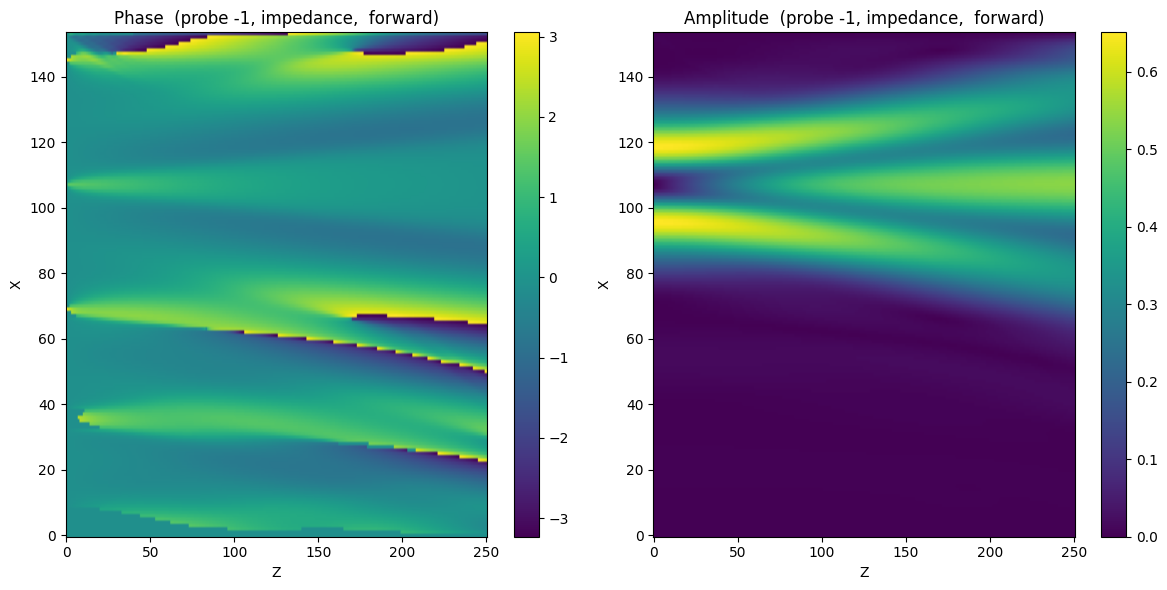

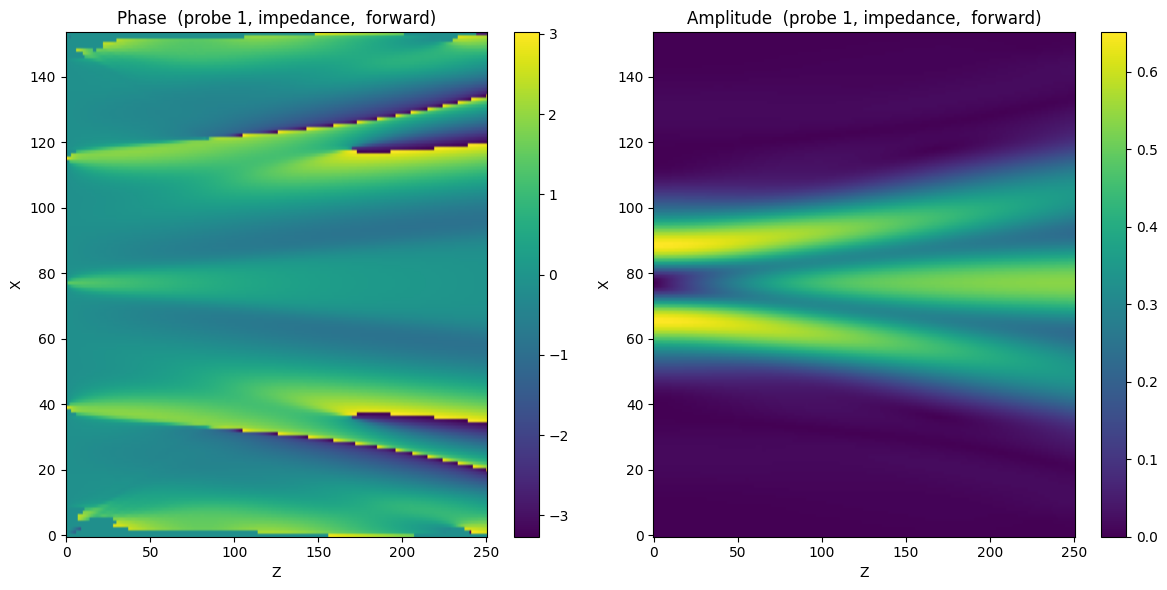

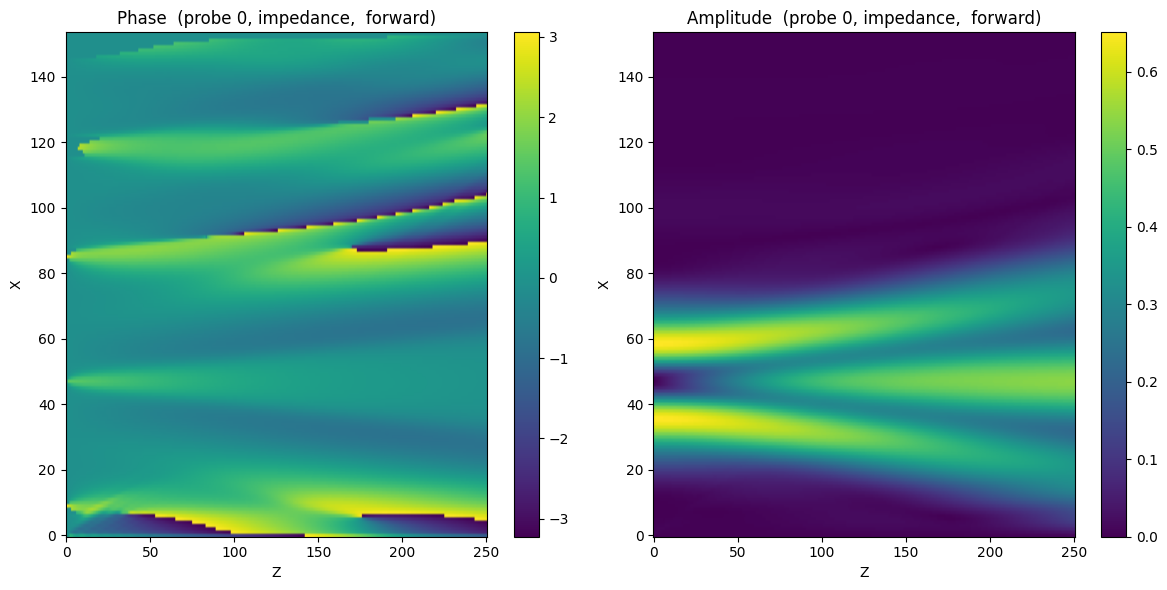

In [87]:
difference = solution_iterative_full_homogeneous - solution_iterative_full
# Plot Solution for Full Sample Solves
visualisation.plot(solution=difference,probe_index=-1)
visualisation.plot(solution=difference)
visualisation.plot(solution=difference,probe_index=0)